# Randomly subsample genome

How does accuracy vary with genome completeness, for each condition/model?

Data:

- 10 genomes for each condition
- Even spacing across predicted values
- Identified in another notebook



How does subsampling work?
- Takes random % of each contig
- Take random % of proteins


In [29]:
import datetime
import sys
from pathlib import Path
import json 
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import pandas as pd
import sys
sys.path.append("../")
from genomic_spot.helpers import rename_condition_to_variable, load_train_and_test_sets
ROOT_DIR = str(Path().resolve().parent)
plt.rcParams['svg.fonttype'] = 'none'

sys.path.append('../')
plt.style.use(f'{ROOT_DIR}/notebooks/project.mplstyle')

units = {
    'temperature' : u'\N{DEGREE SIGN}C',
    'ph' : 'pH',
    'salinity' : '% w/v NaCl',
    'oxygen' : 'Probability'
}

plot_formats = {
    'oxygen' : 'Oxygen Tolerance',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
    'temperature_min' : 'Temperature, Minimum',
    'salinity_min' : 'Salinity, Minimum',
    'ph_min' : 'pH, Minimum',
    'temperature_max' : 'Temperature, Maximum',
    'salinity_max' : 'Salinity, Maximum',
    'ph_max' : 'pH, Maximum',
}


## Get genomes to test

In [2]:
sers = []
for tsv in glob(f"../data/predictions/*.predictions.tsv"):
    try:
        predictions_df = pd.read_csv(tsv, sep='\t', index_col=0)
        accession = tsv.split('/')[-1][:-len('.predictions.tsv')]
        ser = predictions_df['value']
        ser.name = accession
        sers.append(ser)
    except:
        pass

predictions_df = pd.concat(sers,axis=1).T
predictions_df

target           oxygen    ph_max    ph_min  ph_optimum  salinity_max  \
GCA_900537995  0.000341  9.615705  6.009947    7.709260      6.618236   
GCA_010994245  0.983036  9.819209  5.389993    7.427742      1.484435   
GCA_014642875  0.975182  8.334303  4.938631    6.501141      4.977786   
GCA_025821665  0.958858  9.012780  4.841343    6.778810      5.564799   
GCA_002162375  0.939177  9.854402  6.132489    7.951707      7.873819   
...                 ...       ...       ...         ...           ...   
GCA_001467525  0.909246  9.711974  5.662876    7.532405      2.845951   
GCA_900169535  0.767102  9.109150  5.541656    7.308866      8.169874   
GCA_003967355  0.885212  9.003890  4.905388    6.742576      8.486547   
GCA_009829925  0.919213  8.866020  5.121014    6.898838      4.797164   
GCA_014651135  0.891564  9.110551  5.013624    6.835490      9.350715   

target         salinity_min  salinity_optimum  temperature_max  \
GCA_900537995      2.428143          4.260767        47.892852   
GCA_010994245      0.000000          0.000000        36.267892   
GCA_014642875      0.000000          1.099851        37.840509   
GCA_025821665      1.882745          3.860884        41.353620   
GCA_002162375      0.756093          3.183162        35.601662   
...                     ...               ...              ...   
GCA_001467525      0.000000          1.806156        35.455794   
GCA_900169535      0.000000          2.037091        50.490530   
GCA_003967355      1.832436          3.862802        39.538797   
GCA_009829925      0.000000          0.000000        43.375592   
GCA_014651135      1.388200          3.916084        46.812973   

target         temperature_min  temperature_optimum  
GCA_900537995        23.642944            37.969341  
GCA_010994245        11.064024            27.316905  
GCA_014642875        11.848390            27.968164  
GCA_025821665        20.120449            33.360916  
GCA_002162375        10.543946            28.240999  
...                        ...                  ...  
GCA_001467525        18.624838            28.251180  
GCA_900169535        23.112947            40.097188  
GCA_003967355        17.057287            30.639582  
GCA_009829925        14.966473            34.387047  
GCA_014651135        26.064757            36.966456  

[15602 rows x 10 columns]

In [5]:
from collections import defaultdict
PATH_TO_HOLDOUTS = '../data/holdouts/'

genomes_to_test = defaultdict(list)
conditions = [ 'oxygen', 'temperature', 'salinity', 'ph', ]
for condition in conditions:
    target = rename_condition_to_variable(condition)
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    X = predictions_df.reindex(train_set)[target].dropna()
    value_bounds = [value for value in np.linspace(X.min(), X.max(),10)]
    #for value in np.linspace(X.min(),X.max(),20):
    print(np.percentile(X, [int(i) for i in np.linspace(0, 100, 20)]))
    for value in np.percentile(X, [int(i) for i in np.linspace(0, 100, 20)]):
        closest_index = X.index[np.argmin(np.abs(X - value))]
        genomes_to_test[target].append(closest_index)
        
genomes_to_test

[3.59875654e-07 3.19355497e-04 1.41148028e-03 3.67601434e-03
 1.15709010e-02 2.20224835e-02 4.94046490e-02 1.90054274e-01
 6.05662426e-01 7.77070639e-01 8.74321508e-01 9.15566930e-01
 9.41146905e-01 9.56717262e-01 9.67992316e-01 9.75646117e-01
 9.83070370e-01 9.87274227e-01 9.91852007e-01 9.99853545e-01]
[15.96093793 21.54935727 23.32475496 24.56460795 25.7366653  26.65359067
 27.47505347 28.12872971 28.92537744 29.58882892 30.30106375 31.23621623
 32.42638183 33.37764142 34.58239494 36.24316204 39.16750034 44.05330613
 53.98058051 94.36394687]
[ 0.          1.21250107  1.59852603  2.10798608  2.50804294  2.88914144
  3.20181103  3.46838566  3.72493302  3.90499774  4.02415287  4.31568638
  4.9274648   5.54073873  6.28165345  7.05086091  8.41892885 17.30502672
 18.7171885  21.82077238]
[2.89842423 5.45947351 5.88776655 6.22002274 6.5908306  6.80604691
 6.92530573 7.02374339 7.11737273 7.22881881 7.30206345 7.40634643
 7.53338757 7.61070038 7.74237462 7.87785681 8.07337393 8.21950488
 8.

defaultdict(list,
            {'oxygen': ['GCA_004310395',
              'GCA_015163485',
              'GCA_001643775',
              'GCA_003814835',
              'GCA_900115655',
              'GCA_000745975',
              'GCA_013389365',
              'GCA_000373185',
              'GCA_013201705',
              'GCA_001544015',
              'GCA_011927685',
              'GCA_001029435',
              'GCA_900447645',
              'GCA_002163585',
              'GCA_003177275',
              'GCA_014648315',
              'GCA_014643175',
              'GCA_003788585',
              'GCA_014653155',
              'GCA_900660465'],
             'temperature_optimum': ['GCA_014645015',
              'GCA_004340665',
              'GCA_000422265',
              'GCA_003149515',
              'GCA_001043175',
              'GCA_000429845',
              'GCA_014203705',
              'GCA_900105015',
              'GCA_000521505',
              'GCA_014201785',
              'GCA

In [10]:
from genomic_spot.model_training.taxonomy import TaxonomyGTDB
taxonomy = TaxonomyGTDB()
taxonomy_dict = taxonomy.taxonomy_dict


In [17]:
from collections import Counter

for target, genomes in genomes_to_test.items():
    species = []
    for genome in genomes:
        species.extend([taxonomy.taxonomy_dict[genome][-1]])
    print([k for k, v in Counter(species).items() if v > 1])

[]
[]
[]
[]


## Subsample

In [6]:
subsample_portions = np.linspace(0.1, 1., 19)
subsample_portions

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [7]:
targets =  [ 'oxygen', 'temperature_optimum', 'temperature_max', 'temperature_min', 'salinity_optimum', 'salinity_max', 'salinity_min', 'ph_optimum', 'ph_max', 'ph_min', ]

In [8]:
from genomic_spot.bioinformatics.genome import Genome
from genomic_spot.genomic_spot import predict_from_genome

for target, genomes in genomes_to_test.items():
    for genome in genomes:
        contig_filepath = glob(f"{ROOT_DIR}/data/genomes/genbank/*/*/{genome}.*.fna.gz")[0]
        protein_filepath = glob(f"{ROOT_DIR}/data/genomes/genbank/*/*/{genome}.*.faa.gz")[0]
        prefix = contig_filepath.split('/')[-1].split('.')[0]

        print(datetime.datetime.now(), target, genome)
        
        subsample_predictions = {}
        for subsample in subsample_portions:
            try:
                genome_calc = Genome(
                    contig_filepath=contig_filepath, 
                    protein_filepath=protein_filepath,
                    subsample=subsample
                )
                
                genome_features = genome_calc.measure_genome_features()
                predictions = predict_from_genome(genome_features, path_to_models='../models/')
                subsample_predictions[subsample] = {k : d.get('value', np.nan) for k, d in predictions.items()}
            except:
                subsample_predictions[subsample] = {k : np.nan for k in targets}

        filepath = f'../data/subsample_experiment/{prefix}.predictions.json'
        json.dump(subsample_predictions, open(filepath, 'w'))

2024-02-22 11:25:13 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Identifying protein localization


2024-02-22 11:25:13.126771 oxygen GCA_004310395


2024-02-22 11:25:14 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:25:14 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:25:26.669222 oxygen GCA_015163485


2024-02-22 11:25:27 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:25:27 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:25:47.451145 oxygen GCA_001643775


2024-02-22 11:25:48 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:25:48 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:26:07.788530 oxygen GCA_003814835


2024-02-22 11:26:08 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:26:08 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:26:27.164821 oxygen GCA_900115655


2024-02-22 11:26:28 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:26:28 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/ty

2024-02-22 11:26:53.377922 oxygen GCA_000745975


2024-02-22 11:26:55 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:26:55 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 11:27:37.867650 oxygen GCA_013389365


2024-02-22 11:27:39 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:27:39 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:28:17.780906 oxygen GCA_000373185


2024-02-22 11:28:18 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:28:19 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 11:28:47.970145 oxygen GCA_013201705


2024-02-22 11:28:48 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:28:48 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:29:12.815274 oxygen GCA_001544015


2024-02-22 11:29:14 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:29:14 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:29:49.955715 oxygen GCA_011927685


2024-02-22 11:29:51 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:29:51 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:30:32.184973 oxygen GCA_001029435


2024-02-22 11:30:33 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:30:34 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:31:18.707431 oxygen GCA_900447645


2024-02-22 11:31:20 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:31:20 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_ph

2024-02-22 11:32:14.569335 oxygen GCA_002163585


2024-02-22 11:32:17 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:32:17 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:33:05.332576 oxygen GCA_003177275


2024-02-22 11:33:06 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:33:06 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:33:29.769603 oxygen GCA_014648315


2024-02-22 11:33:31 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:33:31 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:34:12.004663 oxygen GCA_014643175


2024-02-22 11:34:13 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:34:13 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:34:52.111878 oxygen GCA_003788585


2024-02-22 11:34:53 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:34:53 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:35:34.197423 oxygen GCA_014653155


2024-02-22 11:35:36 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:35:36 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:36:28.335008 oxygen GCA_900660465


2024-02-22 11:36:28 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:36:28 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting protein statistics
2024-02-22 11:36:28 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Identifying protein localization
2024-02-22 11:36:29 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:36:29 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting protein statistics
2024-02-22 11:36:29 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Identifying protein localization
2024-02-22 11:36:29 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:36:29 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fi

2024-02-22 11:36:40.021346 temperature_optimum GCA_014645015


2024-02-22 11:36:41 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:36:41 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:38:43.442285 temperature_optimum GCA_004340665


2024-02-22 11:38:45 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:38:46 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:39:48.753093 temperature_optimum GCA_000422265


2024-02-22 11:39:50 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:39:50 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 11:40:28.159336 temperature_optimum GCA_003149515


2024-02-22 11:40:30 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:40:30 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:41:30.906358 temperature_optimum GCA_001043175


2024-02-22 11:41:32 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:41:32 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 11:42:21.769743 temperature_optimum GCA_000429845


2024-02-22 11:42:24 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:42:24 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 11:43:20.906920 temperature_optimum GCA_014203705


2024-02-22 11:43:25 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:43:25 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:58:11.455860 temperature_optimum GCA_900105015


2024-02-22 11:58:12 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:58:12 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/ty

2024-02-22 11:58:29.977889 temperature_optimum GCA_000521505


2024-02-22 11:58:31 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:58:31 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 11:59:12.320391 temperature_optimum GCA_014201785


2024-02-22 11:59:13 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:59:13 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 11:59:42.727920 temperature_optimum GCA_002925845


2024-02-22 11:59:44 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 11:59:44 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:00:21.710387 temperature_optimum GCA_024753215


2024-02-22 12:00:23 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:00:23 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:01:10.470931 temperature_optimum GCA_008802405


2024-02-22 12:01:12 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:01:12 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:01:56.216235 temperature_optimum GCA_003696285


2024-02-22 12:01:57 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:01:57 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:02:37.916280 temperature_optimum GCA_016722785


2024-02-22 12:02:40 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:02:40 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:03:38.191118 temperature_optimum GCA_000423525


2024-02-22 12:03:39 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:03:39 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 12:04:01.961744 temperature_optimum GCA_001462205


2024-02-22 12:04:03 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:04:03 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:04:34.865382 temperature_optimum GCA_009466385


2024-02-22 12:04:36 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:04:36 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:05:07.957670 temperature_optimum GCA_001552255


2024-02-22 12:05:09 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:05:09 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:05:44.484387 temperature_optimum GCA_000017945


2024-02-22 12:05:45 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:05:45 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_ph

2024-02-22 12:05:59.359375 salinity_optimum GCA_000017945


2024-02-22 12:05:59 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:05:59 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_ph

2024-02-22 12:06:14.312976 salinity_optimum GCA_014905615


2024-02-22 12:06:15 INFO GCA_014905615.1_ASM1490561v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:06:16 INFO GCA_014905615.1_ASM1490561v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:06:56.542686 salinity_optimum GCA_003201285


2024-02-22 12:06:58 INFO GCA_003201285.1_ASM320128v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:06:58 INFO GCA_003201285.1_ASM320128v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:07:41.767725 salinity_optimum GCA_000381085


2024-02-22 12:07:42 INFO GCA_000381085.1_ASM38108v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:07:42 INFO GCA_000381085.1_ASM38108v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 12:08:06.362937 salinity_optimum GCA_002915595


2024-02-22 12:08:07 INFO GCA_002915595.1_ASM291559v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:08:08 INFO GCA_002915595.1_ASM291559v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:08:46.336216 salinity_optimum GCA_002287065


2024-02-22 12:08:47 INFO GCA_002287065.1_ASM228706v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:08:47 INFO GCA_002287065.1_ASM228706v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:09:22.094841 salinity_optimum GCA_900101475


2024-02-22 12:09:24 INFO GCA_900101475.1_IMG-taxon_2617270884_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:09:24 INFO GCA_900101475.1_IMG-taxon_2617270884_annotated_assembly_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/ty

2024-02-22 12:10:11.429880 salinity_optimum GCA_004004515


2024-02-22 12:10:12 INFO GCA_004004515.1_ASM400451v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:10:12 INFO GCA_004004515.1_ASM400451v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:10:42.997254 salinity_optimum GCA_005884405


2024-02-22 12:10:44 INFO GCA_005884405.1_ASM588440v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:10:44 INFO GCA_005884405.1_ASM588440v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:11:09.880913 salinity_optimum GCA_000425625


2024-02-22 12:11:11 INFO GCA_000425625.1_ASM42562v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:11:11 INFO GCA_000425625.1_ASM42562v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 12:11:57.230154 salinity_optimum GCA_900167125


2024-02-22 12:11:58 INFO GCA_900167125.1_IMG-taxon_2568526008_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:11:58 INFO GCA_900167125.1_IMG-taxon_2568526008_annotated_assembly_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/ty

2024-02-22 12:12:27.244939 salinity_optimum GCA_001602375


2024-02-22 12:12:28 INFO GCA_001602375.1_ASM160237v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:12:28 INFO GCA_001602375.1_ASM160237v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:12:52.031549 salinity_optimum GCA_900105445


2024-02-22 12:12:53 INFO GCA_900105445.1_IMG-taxon_2634166844_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:12:53 INFO GCA_900105445.1_IMG-taxon_2634166844_annotated_assembly_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/ty

2024-02-22 12:13:20.309239 salinity_optimum GCA_900114235


2024-02-22 12:13:21 INFO GCA_900114235.1_IMG-taxon_2636415975_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:13:21 INFO GCA_900114235.1_IMG-taxon_2636415975_annotated_assembly_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/ty

2024-02-22 12:13:46.040288 salinity_optimum GCA_001999905


2024-02-22 12:13:47 INFO GCA_001999905.1_ASM199990v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:13:47 INFO GCA_001999905.1_ASM199990v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:14:27.030400 salinity_optimum GCA_900100655


2024-02-22 12:14:28 INFO GCA_900100655.1_IMG-taxon_2654587884_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:14:28 INFO GCA_900100655.1_IMG-taxon_2654587884_annotated_assembly_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/ty

2024-02-22 12:14:56.787423 salinity_optimum GCA_001311865


2024-02-22 12:14:58 INFO GCA_001311865.1_ASM131186v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:14:58 INFO GCA_001311865.1_ASM131186v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:15:38.379116 salinity_optimum GCA_014646875


2024-02-22 12:15:39 INFO GCA_014646875.1_ASM1464687v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:15:39 INFO GCA_014646875.1_ASM1464687v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:16:08.943933 salinity_optimum GCA_008831545


2024-02-22 12:16:10 INFO GCA_008831545.1_ASM883154v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:16:10 INFO GCA_008831545.1_ASM883154v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:16:54.479560 salinity_optimum GCA_900215575


2024-02-22 12:16:55 INFO GCA_900215575.1_IMG-taxon_2728369221_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:16:55 INFO GCA_900215575.1_IMG-taxon_2728369221_annotated_assembly_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/ty

2024-02-22 12:17:27.629805 ph_optimum GCA_000258425


2024-02-22 12:17:28 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:17:28 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 12:17:41.972203 ph_optimum GCA_900112405


2024-02-22 12:17:42 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:17:42 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/ty

2024-02-22 12:17:55.575376 ph_optimum GCA_001571045


2024-02-22 12:17:56 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:17:56 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:18:25.700860 ph_optimum GCA_016865235


2024-02-22 12:18:27 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:18:27 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:19:10.593175 ph_optimum GCA_013408745


2024-02-22 12:19:12 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:19:12 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:19:49.802752 ph_optimum GCA_000429985


2024-02-22 12:19:51 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:19:51 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 12:20:27.033822 ph_optimum GCA_001613245


2024-02-22 12:20:29 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:20:30 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:21:37.432144 ph_optimum GCA_014647975


2024-02-22 12:21:40 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:21:41 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:23:06.184957 ph_optimum GCA_008271285


2024-02-22 12:23:07 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:23:08 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:23:50.760723 ph_optimum GCA_014653155


2024-02-22 12:23:52 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:23:52 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:24:30.751715 ph_optimum GCA_001982615


2024-02-22 12:24:32 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:24:33 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:25:27.954178 ph_optimum GCA_014197145


2024-02-22 12:25:29 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:25:29 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:26:15.295134 ph_optimum GCA_000974365


2024-02-22 12:26:17 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:26:17 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

2024-02-22 12:27:01.763870 ph_optimum GCA_004291315


2024-02-22 12:27:04 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:27:04 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:28:07.646956 ph_optimum GCA_003594815


2024-02-22 12:28:09 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:28:09 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:28:43.607426 ph_optimum GCA_017873955


2024-02-22 12:28:44 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:28:44 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:29:16.588507 ph_optimum GCA_014197055


2024-02-22 12:29:18 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:29:18 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/v

2024-02-22 12:29:52.905424 ph_optimum GCA_003317055


2024-02-22 12:29:54 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:29:54 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:30:21.534448 ph_optimum GCA_001562195


2024-02-22 12:30:23 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:30:23 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/ven

2024-02-22 12:31:02.002226 ph_optimum GCA_000306965


2024-02-22 12:31:03 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting genome statistics
2024-02-22 12:31:03 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting protein statistics
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_

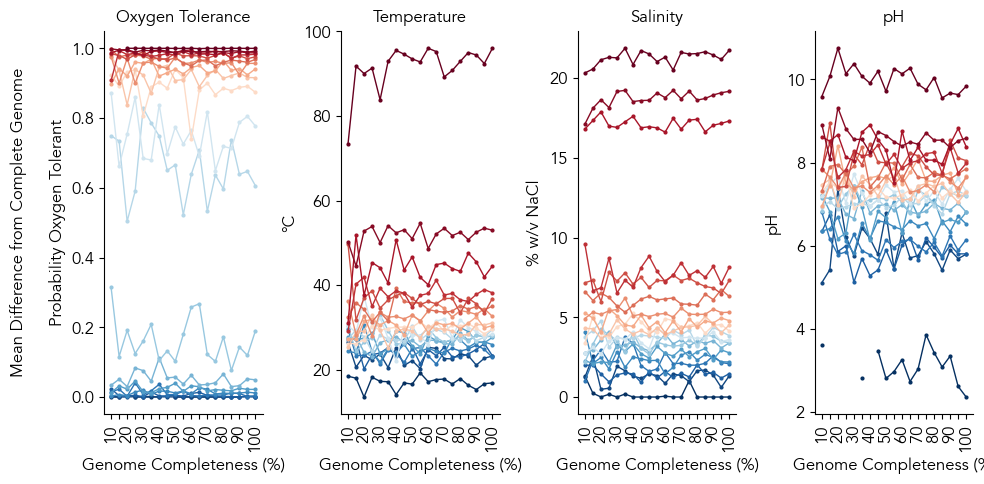

In [22]:
import matplotlib.pyplot as plt
N = 20


plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.RdBu_r(np.array(list(np.linspace(0,0.4,int(N/2))) + list(np.linspace(0.6,1,int(N/2))))))
targets =  [ 'oxygen', 'temperature_optimum', 'temperature_max', 'temperature_min', 'salinity_optimum', 'salinity_max', 'salinity_min', 'ph_optimum', 'ph_max', 'ph_min', ]
fig, axes = plt.subplots(1,4, figsize=(10,5))
axl = axes.flatten()
for n, condition in enumerate(['oxygen', 'temperature', 'salinity', 'ph']):
    target = rename_condition_to_variable(condition)
    genomes = genomes_to_test[target]
    ax = axl[n]
    for genome in genomes:
        filepath = glob(f"{ROOT_DIR}/data/subsample_experiment/{genome}*.predictions.json")[0]
        subsample_predictions = json.loads(open(filepath, 'r').read())


        if condition == 'oxygen':
            target = condition
        else:
            target = condition + '_optimum'

        data = pd.DataFrame(subsample_predictions)                

        Y = data.loc[target]
        X = 100 * subsample_portions
        ax.plot(X, Y, label=genome, marker='o', markersize=2)
            
    #ax.legend(bbox_to_anchor=(1,1))
    
    ax.set_title(plot_formats[condition])
    ax.set_xticks(X)
    ax.set_xticklabels([f"{int(x)}" if n % 2 == 0 else '' for n, x in enumerate(X) ], rotation=90)
    ax.set_xlabel('Genome Completeness (%)')
    if n == 0:
        ax.set_ylabel(f'Mean Difference from Complete Genome\n\n{units[condition]}')
    else:
        ax.set_ylabel(f'{units[condition]}')

plt.tight_layout()

In [ ]:
diffs.shape, len(data.columns)

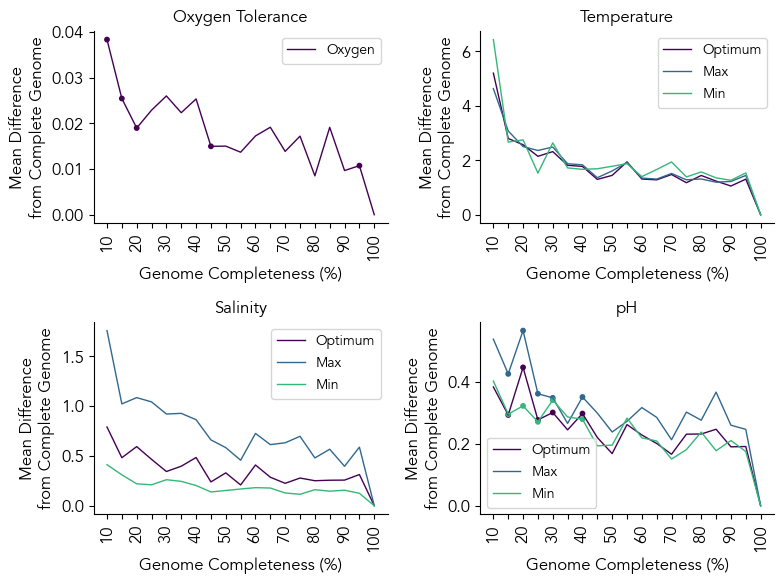

In [23]:
plot_formats = {
    'oxygen' : 'Oxygen Tolerance',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
}


import matplotlib.pyplot as plt
N = 4
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))

targets =  [ 'oxygen', 'temperature_optimum', 'temperature_max', 'temperature_min', 'salinity_optimum', 'salinity_max', 'salinity_min', 'ph_optimum', 'ph_max', 'ph_min', ]

fig, axes = plt.subplots(2,2, figsize=(8,6))
axl = axes.flatten()
for n, condition in enumerate(['oxygen', 'temperature', 'salinity', 'ph']):
#for condition, genomes in genomes_to_test.items():
    target = rename_condition_to_variable(condition)
    genomes = genomes_to_test[target]
    ax = axl[n]
    for target in targets:
        
        if condition in target:
            
            diffs = []
            for genome in genomes:
                filepath = glob(f"{ROOT_DIR}/data/subsample_experiment/{genome}*.predictions.json")[0]
                subsample_predictions = json.loads(open(filepath, 'r').read())
                #print(genome)
                data = pd.DataFrame(subsample_predictions)                
                diff = np.abs(data.loc[target] - data.loc[target, '1.0'])
                diffs.append(diff)

            diffs = np.array(diffs)
            Y = np.nanmean(diffs, axis=0)
            X = 100 * subsample_portions

            S = (0 + 10 * np.sum(np.isnan(diffs),axis=0)) 
            ax.plot(X, Y, label=target.split('_')[-1].capitalize())
            ax.scatter(X, Y, s=S, clip_on=False)
                    
    ax.legend(fontsize=10)
    ax.set_title(plot_formats[condition])
    ax.set_xticks(X)
    ax.set_xticklabels([f"{int(x)}" if n % 2 == 0 else '' for n, x in enumerate(X) ], rotation=90)
    ax.set_xlabel('Genome Completeness (%)')
    ax.set_ylabel('Mean Difference\nfrom Complete Genome')

plt.tight_layout()

0.038315443466731665
5.204520198597694
0.7914775831163048
0.44640074619540143


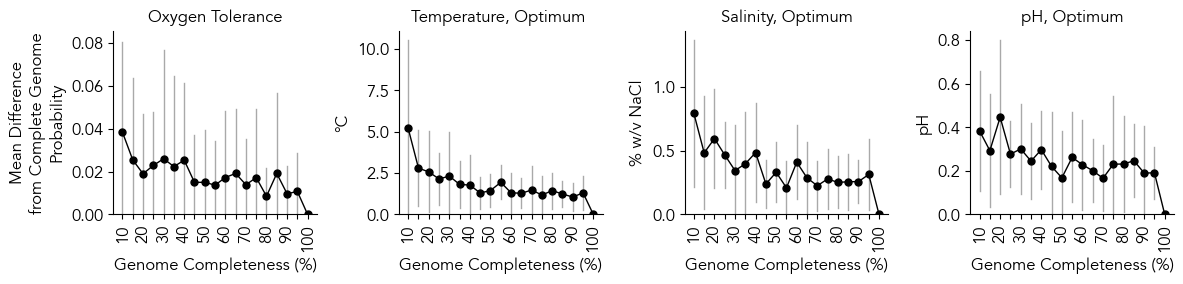

In [30]:
plot_formats = {
    'oxygen' : 'Oxygen Tolerance',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
}

targets = ['oxygen', 'temperature_optimum', 'salinity_optimum', 'ph_optimum']

import matplotlib.pyplot as plt
N = 4
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))

fig, axes = plt.subplots(1,4,figsize=(12,3))
axl = axes.flatten()
for n, condition in enumerate(['oxygen', 'temperature', 'salinity', 'ph']):
    target = rename_condition_to_variable(condition)
    genomes = genomes_to_test[target]
    
    ax = axl[n]
    for target in targets:
        
        if condition in target:
            
            diffs = []
            for genome in genomes:
                filepath = glob(f"{ROOT_DIR}/data/subsample_experiment/{genome}*.predictions.json")[0]
                subsample_predictions = json.loads(open(filepath, 'r').read())
                #print(genome)
                data = pd.DataFrame(subsample_predictions)                
                diff = np.abs(data.loc[target] - data.loc[target, '1.0'])
                diffs.append(diff)

            diffs = np.array(diffs)
            Yerr = np.nanstd(diffs, axis=0) #/ np.nanmean(diffs, axis=0)
            Y = np.nanmean(diffs, axis=0)
            X = 100 * subsample_portions
            print(Y.max())

            S = (0 + 10 * np.sum(np.isnan(diffs),axis=0)) 
            ax.plot(X, Y,  marker='.', color='black')
            #ax.errorbar(X, Y, Yerr, marker='.', color='black')
            #ax.scatter(X, Y, s=S, clip_on=False)
            for x, y, yerr in zip(X, Y, Yerr):
                ax.plot([x,x], [y-yerr, y+yerr], color='darkgray', zorder=0, lw=1, clip_on=True)
                    
    #ax.legend(fontsize=10)
            ax.set_title(plot_formats[target])
    ax.set_xticks(X)
    ax.set_xticklabels([f"{int(x)}" if n % 2 == 0 else '' for n, x in enumerate(X) ], rotation=90)
    ax.set_xlabel('Genome Completeness (%)')
    if n == 0:
        ax.set_ylabel(f'Mean Difference\nfrom Complete Genome\n{units[condition]}')
    else:
        ax.set_ylabel(f'{units[condition]}')
    ax.set_ylim([0, ax.get_ylim()[1]])

plt.tight_layout()
plt.savefig("fig-2d.svg",  format="svg")
plt.show()